# STFT

$$
X[m;k] = \sum_{n=0}^{L-1}x[m+n]e^{-j2{\pi}nk/L}
$$

__STFT Parameters__
* $m :=$ which sample the current stft window is starting on. $m \in [0,N-m]$
    * $\Delta m := $ how much $m$ is shifted each time
* $L :=$ window size
    * Higher $L$ gives more frequency resolution, less time resolution. Better for recognizing vowels.
    * Lower $L$ gives more time resolution, less frequency resolution. Better for recognizing consonants.
* $k :=$ frequency index. $k \in [0, L]$
* _Convolution_ i.e. how the discrete time sample $x$ is weighted before being DFT'd

In [139]:
from IPython.display import Audio
import numpy as np
import matplotlib.pyplot as plt
import warnings
# warnings.filterwarnings("ignore", category=RuntimeWarning) 

# freq_spec = np.arange(L) * fs/L

def gen_signal(f, fs, t, pad=0.):
    """
    generates a sample of length [t] seconds sampled at [fs]hz with frequency [f]
    pad with [pad] seconds of silence
    """
    dt = 1. / fs  # time between samples
    N = fs * t  # no. samples
    n = np.arange(N)  # sample indexes
    n_t = n * dt  # time indexes
    silence = np.zeros(int(fs*pad))
    return np.concatenate([silence, np.sin(2. * np.pi * f * n_t), silence])

def gen_forward_matrix(N):
    """ matrix for DFT """
#     ns = np.arange(N)
#     ks = np.array([ns]).T
#     return np.exp(-1j * 2 * np.pi * ks * ns / N)
    ns = np.arange(N)
    ks = np.array([ns]).T
    return np.exp(-1j * 2 * np.pi * ks * ns / N)
    

def gen_inverse_matrix(N):
    return gen_forward_matrix(N).conjugate().T

def dft(x, M=None):
    if M is None:
        M = gen_forward_matrix(len(x))
    return np.dot(M, x)

def inv_dft(x, M=None):
    if M is None:
        M = gen_inverse_matrix(len(x))
    return np.dot(M, x)
    


    

In [140]:
fs = 44_100

test_signal = np.concatenate([gen_signal(f, fs, 1, pad=.2) for f in (1000, 5000, 10000)  ])

In [141]:
Audio(test_signal, rate=fs)

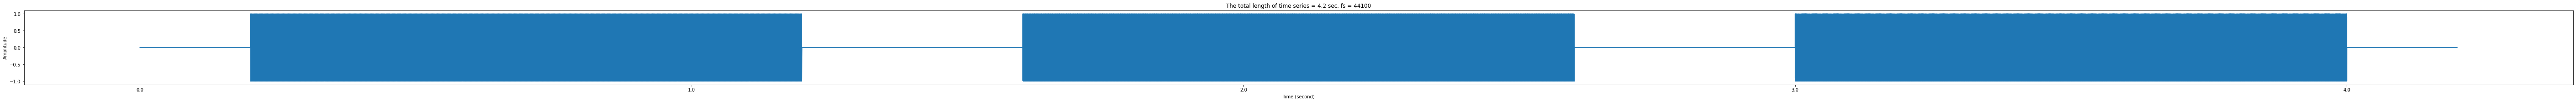

In [142]:
total_ts_sec = len(test_signal)/fs
tt = np.arange(len(test_signal))
plt.figure(figsize=(100,3))
plt.plot(test_signal)
plt.xticks(np.arange(0,len(test_signal),fs),
           np.arange(0,len(test_signal)/fs,1))
plt.ylabel("Amplitude")
plt.xlabel("Time (second)")
plt.title("The total length of time series = {} sec, fs = {}".format(len(test_signal)/fs, fs))
plt.show()

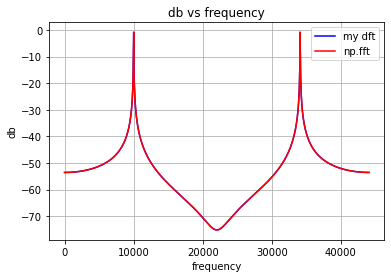

In [143]:
# this is to sanity check my dft implementation works
tmp = gen_signal(10000, fs, 1)
N = 1000
freq_spec = np.arange(N)*fs/N
# my_dft = 2/N * np.abs(dft(test_signal[:N]))
# my_dft = 20. * np.where(my_dft>0., np.log10(my_dft), 0)

my_dft = 20. * np.log10(2/N * np.abs( dft(tmp[:N]) ) )
np_fft = 20. * np.log10(2/N * np.abs( np.fft.fft(tmp[:N]) ) )

plt.plot(freq_spec, my_dft, color = "blue", label = "my dft")
plt.plot(freq_spec, np_fft, color = "red", label = "np.fft")
plt.grid()
plt.legend(loc = 'upper right')
plt.title("db vs frequency")
plt.xlabel("frequency")
plt.ylabel("db")
plt.show()


In [144]:

# implement hanning window fn
def apply_hanning(x):
    N = len(x)
    w = [0.5*(1-np.cos((2*np.pi*n)/N)) for n in range(0,N)]
    return x * w
def inv_hanning(y):
    N = len(y)
    w = [0.5*(1-np.cos((2*np.pi*n)/N)) for n in range(0,N)]
    
#     n = np.arange(0, 1, 1/N)
#     w = (N/2*np.pi)*np.arccos((1-(2*n)))
    return y / w
def check_hanning(x):
    count = 0
    N = len(x)
    w = [0.5*(1-np.cos((2*np.pi*n)/N)) for n in range(0,N)]
    han = apply_hanning(x)
    ihan = inv_hanning(han)
    truths = np.array(inv_hanning(apply_hanning(x))== x)
    print(truths)
    for i in range(len(truths)):
        if truths[i]:
            count += 1
        else: 
            print(x[i], w[i], x[i]*w[i] == han[i])
            print("then!!!!", x[i], ihan[i])
    return count, len(x)
def apply_hamming(x):
    N = len(x)
    w = [0.54 - (0.46*np.cos(2*np.pi*n/N)) for n in range(0, N)]
    return x * w
def inv_hamming(x):
    N = len(x)
    w = [(N/2*np.pi)*np.arccos(-1*(n-0.54)/0.46) for n in range(0,N)]

<ipython-input-145-f0b13fab06cf>:27: RuntimeWarning: divide by zero encountered in log10
  stft_db = 20*np.log10(np.abs(stft[:L//2, :])*2)


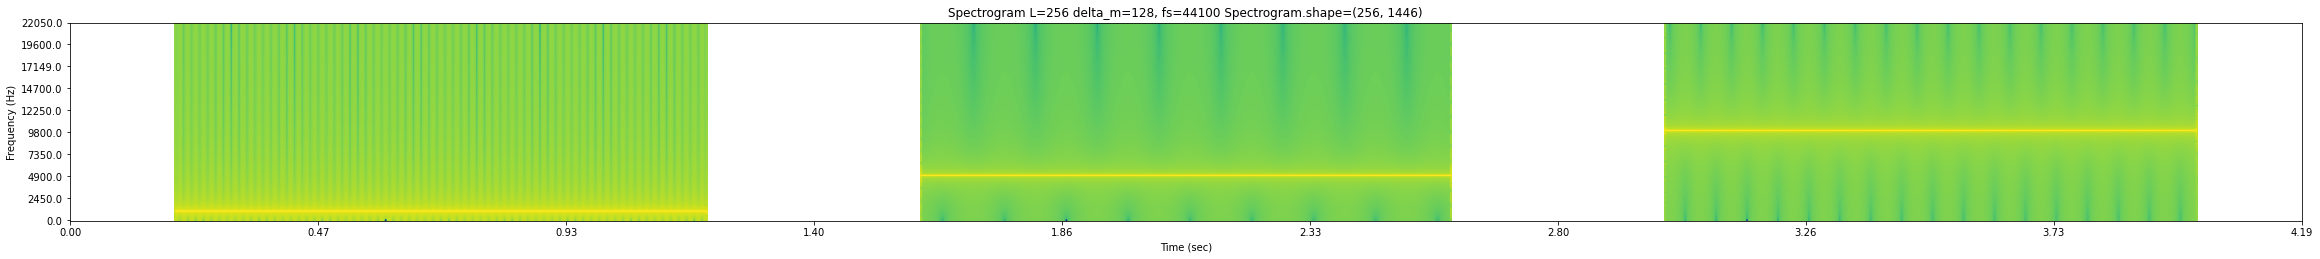

In [145]:
def get_stft(signal, L, delta_m, conv=None):
    """
    :param signal: time-sampled signal
    :param L: window size per DFT in samples
    :param delta_m: how many samples the window is moved 
    :param conv: convolution function for signal
    """
    N = len(signal)
    M = gen_forward_matrix(L)
    ms = np.arange(0, N-L, delta_m)
    dfts = None
    for m in ms:
        window = signal[m:m+L]
        if conv:
            window = conv(window)
        freq_window = np.array([dft(window, M=M)]).T
        dfts = freq_window if dfts is None else np.hstack([
            dfts, 
            freq_window
        ])
    return ms, dfts

def plot_spectrogram(ms, stft, fs):    
    plt.figure(figsize=[40,40])
    L = stft.shape[0]
    # we only look at DFT freq up to nyquist limit fs/2, and normalize out imag components
    stft_db = 20*np.log10(np.abs(stft[:L//2, :])*2)
    plt_spec = plt.imshow(
        stft_db,
        origin='lower'
    )
    
    ## create ylim
    num_yticks = 10
    ks = np.linspace(0, L/2, num_yticks)
    ks_hz = ks * fs // (L)
    plt.yticks(ks,ks_hz)
    plt.ylabel("Frequency (Hz)")

    ## create xlim
    num_xticks = 10
    ts_spec = np.linspace(0, len(ms), num_xticks)
    ts_spec_sec  = ["{:4.2f}".format(i) for i in np.linspace(0, ms[-1]/fs, num_xticks)]
    plt.xticks(ts_spec,ts_spec_sec)
    plt.xlabel("Time (sec)")

    plt.title(f"Spectrogram L={L} delta_m={delta_m}, fs={fs} Spectrogram.shape={stft.shape}")
#     plt.colorbar(None, use_gridspec=True)
    plt.show()
    return(plt_spec)

L = 256
delta_m = 128
ms, stft = get_stft(test_signal[:], L, delta_m)
plot_spectrogram(ms, stft, fs)

<ipython-input-145-f0b13fab06cf>:27: RuntimeWarning: divide by zero encountered in log10
  stft_db = 20*np.log10(np.abs(stft[:L//2, :])*2)


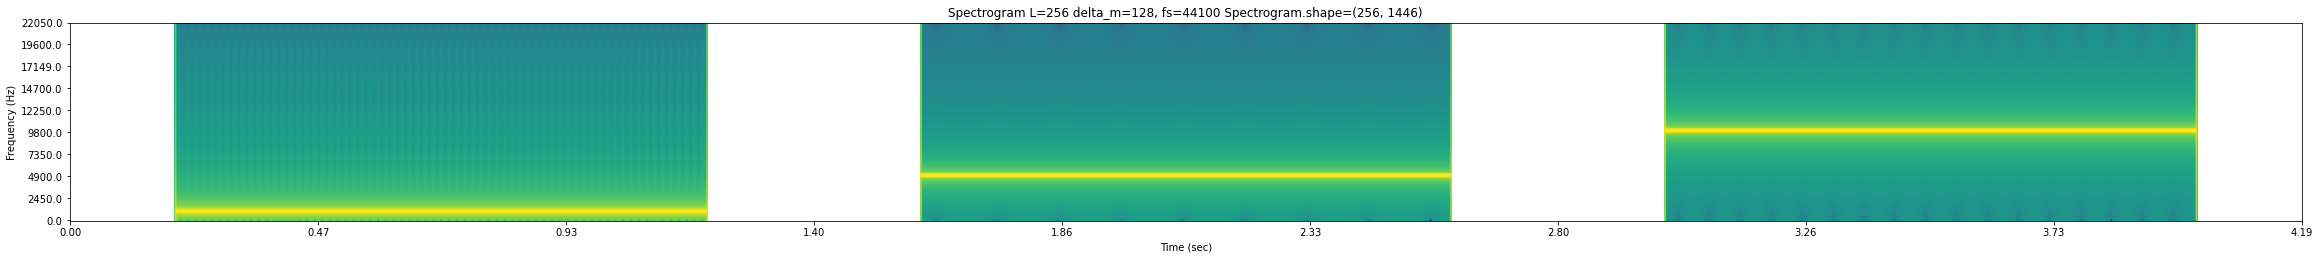

In [146]:
ms, stft = get_stft(test_signal[:], L, delta_m, conv=apply_hanning)
plot_spectrogram(ms, stft, fs)

<ipython-input-145-f0b13fab06cf>:27: RuntimeWarning: divide by zero encountered in log10
  stft_db = 20*np.log10(np.abs(stft[:L//2, :])*2)


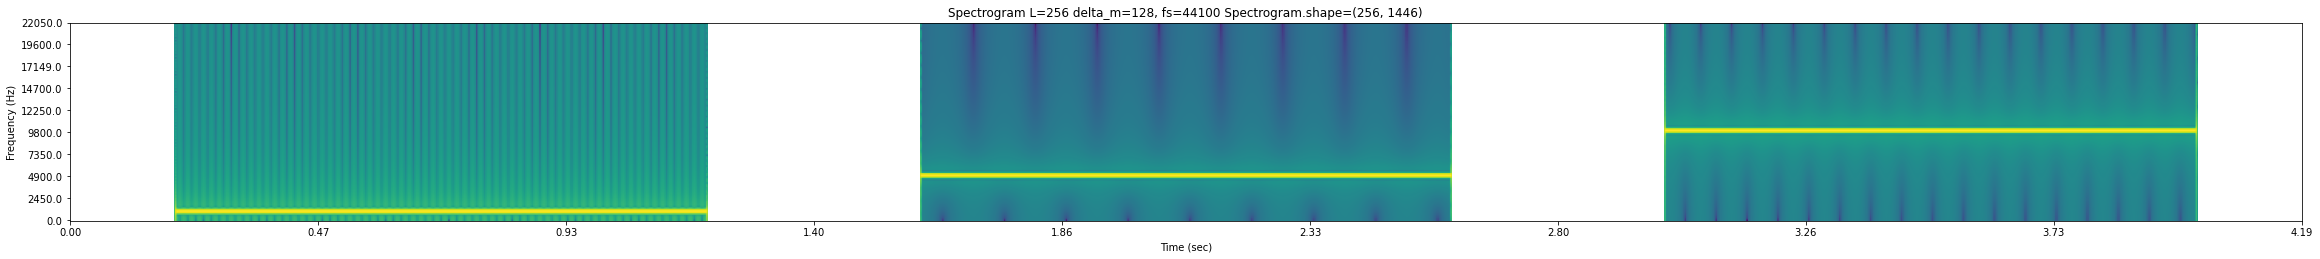

In [147]:
ms, stft = get_stft(test_signal[:], L, delta_m, conv=apply_hamming)
plot_spectrogram(ms, stft, fs)

In [148]:
# reconstruct original signal from stft
def get_istft(stft, delta_m):
    L = stft.shape[0]
    M = gen_inverse_matrix(L)
    signal = np.array([])
    m = delta_m
    for col in range(stft.shape[1]):
        signal_window = inv_dft(stft[:, col], M=M)
        signal = np.concatenate([
            signal[:m],
            signal_window
        ])
        m += delta_m
    return signal * (1/L)


orig_signal = np.concatenate([gen_signal(f, fs, 1, pad=.2) for f in (200, 400, 600)  ])
ms, stft = get_stft(orig_signal, L, delta_m)
reconstructed_signal = get_istft(stft, delta_m)
print(orig_signal.shape)
print(reconstructed_signal.shape)
    


(185220,)
(185344,)


In [160]:
#windowed signal
orig_signal_hanning = np.concatenate([gen_signal(f, fs, 1, pad=.2) for f in (200, 400, 600)  ])
ms, stft = get_stft(orig_signal, L, delta_m, conv=apply_hanning)

reconstructed_signal_hanning = inv_hanning(reconstructed_signal_hanning) 
reconstructed_signal_hanning = get_istft(stft, delta_m)

<ipython-input-144-196f77c789ac>:12: RuntimeWarning: invalid value encountered in true_divide
  return y / w


In [150]:
Audio(orig_signal, rate=fs)

In [151]:
Audio(reconstructed_signal, rate=fs)

/Users/samsilverstein/opt/anaconda3/lib/python3.8/site-packages/IPython/lib/display.py:157: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


In [152]:
Audio(orig_signal_hanning, rate=fs)

In [161]:
Audio(reconstructed_signal_hanning, rate=fs)

In [154]:
print(reconstructed_signal_hanning[len(reconstructed_signal_hanning)//2])

(2.6853519408120974e-15-2.9698465908722937e-15j)


In [157]:
check_hanning(orig_signal_hanning)

<ipython-input-144-196f77c789ac>:12: RuntimeWarning: invalid value encountered in true_divide
  return y / w


[False  True  True ...  True  True  True]
0.0 0.0 True
then!!!! 0.0 nan
0.11373404759240872 0.022233599360719003 True
then!!!! 0.11373404759240872 0.11373404759240871
0.7544758509208145 0.022363828413331732 True
then!!!! 0.7544758509208145 0.7544758509208144
0.7728692065106031 0.022368844643885277 True
then!!!! 0.7728692065106031 0.772869206510603
0.7906350542454081 0.022373861424076658 True
then!!!! 0.7906350542454081 0.790635054245408
0.8695652954707821 0.022398953569399138 True
then!!!! 0.8695652954707821 0.869565295470782
0.8832818106065943 0.02240397364729635 True
then!!!! 0.8832818106065943 0.8832818106065944
0.8962811717017868 0.022408994274790928 True
then!!!! 0.8962811717017868 0.8962811717017869
0.9501721070958867 0.022434105656022885 True
then!!!! 0.9501721070958867 0.9501721070958866
0.9586678530366607 0.022439129580980655 True
then!!!! 0.9586678530366607 0.9586678530366608
0.973317994624476 0.022449179079561177 True
then!!!! 0.973317994624476 0.9733179946244759
0.984807753

-0.9359843209522087 0.038501208520332064 True
then!!!! -0.9359843209522087 -0.9359843209522088
-0.9255742180269944 0.03850773563449861 True
then!!!! -0.9255742180269944 -0.9255742180269942
-0.9144126230158105 0.038514263279731065 True
then!!!! -0.9144126230158105 -0.9144126230158104
-0.9025085982392733 0.038520791456021886 True
then!!!! -0.9025085982392733 -0.9025085982392734
-0.8160758373504615 0.038559971665571846 True
then!!!! -0.8160758373504615 -0.8160758373504616
-0.21209065141553318 0.03872997345116591 True
then!!!! -0.21209065141553318 -0.21209065141553315
-0.014247103707105866 0.03877580447675 True
then!!!! -0.014247103707105866 -0.014247103707105864
0.0142471037070995 0.03878235388920909 True
then!!!! 0.0142471037070995 0.014247103707099498
0.4530381388406135 0.03888721666540845 True
then!!!! 0.4530381388406135 0.45303813884061356
0.478253978621314 0.03889377509958969 True
then!!!! 0.478253978621314 0.4782539786213141
0.8160758373504662 0.03899878220589936 True
then!!!! 0.816

-0.8730610582747553 0.05225881234342222 True
then!!!! -0.8730610582747553 -0.8730610582747552
-0.9860197875830391 0.05234944311379963 True
then!!!! -0.9860197875830391 -0.9860197875830392
-0.973317994624474 0.05245527276652873 True
then!!!! -0.973317994624474 -0.9733179946244739
-0.9663852375120898 0.05246283589033812 True
then!!!! -0.9663852375120898 -0.9663852375120899
-0.9586678530366587 0.05247039952915439 True
then!!!! -0.9586678530366587 -0.9586678530366588
-0.8551427630053394 0.05253849545237693 True
then!!!! -0.8551427630053394 -0.8551427630053393
-0.8400259231507726 0.05254606424078384 True
then!!!! -0.8400259231507726 -0.8400259231507727
-0.824227049569492 0.05255363354410186 True
then!!!! -0.824227049569492 -0.8242270495694919
-0.7906350542454025 0.05256877369543661 True
then!!!! -0.7906350542454025 -0.7906350542454026
-0.6956825506034727 0.05260663308410907 True
then!!!! -0.6956825506034727 -0.6956825506034728
-0.17013930031661859 0.05276578305555979 True
then!!!! -0.170139

then!!!! -0.991328238114394 -0.9913282381143941
-0.987181783414449 0.07619180871719788 True
then!!!! -0.987181783414449 -0.9871817834144488
-0.9699500612784121 0.0762188105714352 True
then!!!! -0.9699500612784121 -0.969950061278412
-0.9456344796221859 0.07624581681469866 True
then!!!! -0.9456344796221859 -0.945634479622186
-0.9359843209522056 0.07625481987107724 True
then!!!! -0.9359843209522056 -0.9359843209522055
-0.9144126230158068 0.07627282744670844 True
then!!!! -0.9144126230158068 -0.9144126230158067
-0.8898718088114631 0.07629083697276928 True
then!!!! -0.8898718088114631 -0.8898718088114632
-0.8476703774954549 0.07631785491873466 True
then!!!! -0.8476703774954549 -0.847670377495455
-0.4782539786213368 0.07648005473273656 True
then!!!! -0.4782539786213368 -0.47825397862133673
-0.42745446839936085 0.07649808668277747 True
then!!!! -0.42745446839936085 -0.4274544683993609
-0.23984768897481534 0.07656121385884346 True
then!!!! -0.23984768897481534 -0.23984768897481532
-0.212090651

-0.02849131539084063 0.09548153337768672 True
then!!!! -0.02849131539084063 -0.028491315390840634
0.056959498116983316 0.09551144307866799 True
then!!!! 0.056959498116983316 0.05695949811698331
0.6749334134708493 0.0957508714722547 True
then!!!! 0.6749334134708493 0.6749334134708495
0.6956825506035121 0.09576085347133245 True
then!!!! 0.6956825506035121 0.695682550603512
0.7158668492597131 0.0957708359355916 True
then!!!! 0.7158668492597131 0.715866849259713
0.8077589696806935 0.0958207552342063 True
then!!!! 0.8077589696806935 0.8077589696806934
0.8551427630053678 0.09585071239481668 True
then!!!! 0.8551427630053678 0.8551427630053677
0.9501721070958798 0.09593061861903351 True
then!!!! 0.9501721070958798 0.9501721070958797
0.9930998207221562 0.09600056097719167 True
then!!!! 0.9930998207221562 0.9930998207221563
0.998167273242871 0.09602054869241655 True
then!!!! 0.998167273242871 0.9981672732428709
0.9860197875830394 0.09610051814769804 True
then!!!! 0.9860197875830394 0.98601978758

then!!!! 0.9981672732428708 0.9981672732428709
0.9999936564536084 0.13410921959944133 True
then!!!! 0.9999936564536084 0.9999936564536083
0.9996891820008158 0.13412077967766978 True
then!!!! 0.9996891820008158 0.9996891820008157
0.993910036805714 0.13415546243853227 True
then!!!! 0.993910036805714 0.9939100368057139
0.9808720446271266 0.13419014898838139 True
then!!!! 0.9808720446271266 0.9808720446271265
0.9681922164062913 0.13421327545976258 True
then!!!! 0.9681922164062913 0.9681922164062912
0.9606704261456747 0.1342248393268577 True
then!!!! 0.9606704261456747 0.9606704261456748
0.9523686484908576 0.13423640361487155 True
then!!!! 0.9523686484908576 0.9523686484908577
0.9432936238199263 0.13424796832379082 True
then!!!! 0.9432936238199263 0.9432936238199264
0.9334527203256223 0.1342595334536021 True
then!!!! 0.9334527203256223 0.9334527203256222
0.23292580841837193 0.13465299820290355 True
then!!!! 0.23292580841837193 0.2329258084183719
-0.24675739769029917 0.13484991286492665 True

then!!!! 0.46569332433671756 0.4656933243367175
0.8077589696806982 0.1603241527416011 True
then!!!! 0.8077589696806982 0.807758969680698
0.8242270495695114 0.16033659943854195 True
then!!!! 0.8242270495695114 0.8242270495695115
0.8551427630053425 0.16036149400502053 True
then!!!! 0.8551427630053425 0.8551427630053424
0.8832818106066035 0.16038639013486583 True
then!!!! 0.8832818106066035 0.8832818106066036
0.9586678530366604 0.16047353889918375 True
then!!!! 0.9586678530366604 0.9586678530366605
0.9733179946244819 0.16049844206276148 True
then!!!! 0.9733179946244819 0.973317994624482
0.9930998207221572 0.1605482530780118 True
then!!!! 0.9930998207221572 0.9930998207221573
0.9981672732428716 0.160573160929455 True
then!!!! 0.9981672732428716 0.9981672732428717
0.999486216200688 0.16058561544108096 True
then!!!! 0.999486216200688 0.9994862162006881
0.9999936564536084 0.16059807034329066 True
then!!!! 0.9999936564536084 0.9999936564536085
0.9996891820008155 0.16061052563606987 True
then!!

0.9456344796221863 0.1801289264020413 True
then!!!! 0.9456344796221863 0.9456344796221864
0.9972037971811805 0.18024626859011472 True
then!!!! 0.9972037971811805 0.9972037971811804
0.9992325282639967 0.18029843024129089 True
then!!!! 0.9992325282639967 0.9992325282639968
0.9977108512320092 0.18031147157387017 True
then!!!! 0.9977108512320092 0.9977108512320093
0.9953791129491956 0.18032451327433358 True
then!!!! 0.9953791129491956 0.9953791129491955
0.9716586829209652 0.18038972729438718 True
then!!!! 0.9716586829209652 0.9716586829209654
0.9384684220497487 0.18044190513081304 True
then!!!! 0.9384684220497487 0.9384684220497488
0.9172729889159746 0.1804679962554901 True
then!!!! 0.9172729889159746 0.9172729889159745
0.879919489869203 0.18050713570024807 True
then!!!! 0.879919489869203 0.8799194898692031
0.820172254596933 0.1805593267737473 True
then!!!! 0.820172254596933 0.8201722545969331
0.768329121733113 0.18059847393871253 True
then!!!! 0.768329121733113 0.7683291217331131
0.710874

0.18416141324511084 0.20923096650150974 True
then!!!! 0.18416141324511084 0.18416141324511087
0.3752670048793826 0.20932756373541211 True
then!!!! 0.3752670048793826 0.37526700487938264
0.4274544683994238 0.2093551659557793 True
then!!!! 0.4274544683994238 0.42745446839942386
0.4530381388405593 0.20936896756766354 True
then!!!! 0.4530381388405593 0.45303813884055927
0.4782539786212731 0.20938276951399382 True
then!!!! 0.4782539786212731 0.47825397862127306
0.5981105304912282 0.20945178426177857 True
then!!!! 0.5981105304912282 0.5981105304912281
0.8322109517210448 0.20961745375644886 True
then!!!! 0.8322109517210448 0.8322109517210449
0.9699500612784152 0.209783171370161 True
then!!!! 0.9699500612784152 0.9699500612784153
0.9946698137338414 0.2098522345711465 True
then!!!! 0.9946698137338414 0.9946698137338416
0.999942908565361 0.20990749114204732 True
then!!!! 0.999942908565361 0.9999429085653612
0.9992325282639962 0.20992130611937793 True
then!!!! 0.9992325282639962 0.999232528263996

0.9606704261456975 0.27065788989933176 True
then!!!! 0.9606704261456975 0.9606704261456974
0.9523686484908653 0.27067296193041784 True
then!!!! 0.9523686484908653 0.9523686484908654
0.9432936238199348 0.27068803422540383 True
then!!!! 0.9432936238199348 0.9432936238199346
0.9334527203256314 0.2707031067842723 True
then!!!! 0.9334527203256314 0.9334527203256315
-0.48449805901727927 0.2716079425653235 True
then!!!! -0.48449805901727927 -0.4844980590172792
-0.9566166292499507 0.27201542757779484 True
then!!!! -0.9566166292499507 -0.9566166292499508
-0.9835457412105632 0.2720758120020602 True
then!!!! -0.9835457412105632 -0.9835457412105633
-0.9882936815372539 0.27209090876388387 True
then!!!! -0.9882936815372539 -0.9882936815372538
-0.9953791129491967 0.2721211030743185 True
then!!!! -0.9953791129491967 -0.9953791129491968
-0.9992325282639971 0.27215129843368685 True
then!!!! -0.9992325282639971 -0.9992325282639972
-0.9999429085653613 0.27216639650667784 True
then!!!! -0.9999429085653613 

0.8765125147926247 0.30063713157692995 True
then!!!! 0.8765125147926247 0.8765125147926246
0.8898718088114528 0.300652686497074 True
then!!!! 0.8898718088114528 0.8898718088114529
0.9025085982392659 0.30066824164661843 True
then!!!! 0.9025085982392659 0.902508598239266
0.9255742180269986 0.3006993526338372 True
then!!!! 0.9255742180269986 0.9255742180269985
0.9359843209522177 0.30071490847147586 True
then!!!! 0.9359843209522177 0.9359843209522176
0.9545168588814635 0.30074602083472174 True
then!!!! 0.9545168588814635 0.9545168588814634
0.9626242469499972 0.3007615773602933 True
then!!!! 0.9626242469499972 0.962624246949997
0.997203797181183 0.3008704794579972 True
then!!!! 0.997203797181183 0.9972037971811831
0.9989281310649488 0.30088603781726897 True
then!!!! 0.9989281310649488 0.9989281310649487
0.9999429085653614 0.30091715522319074 True
then!!!! 0.9999429085653614 0.9999429085653613
0.9992325282639977 0.3009327142698048 True
then!!!! 0.9992325282639977 0.9992325282639976
0.9977108

then!!!! 0.19814614319931984 0.1981461431993198
0.3884347962748122 0.33155856672774325 True
then!!!! 0.3884347962748122 0.38843479627481214
0.4907175520038972 0.3316224481134936 True
then!!!! 0.4907175520038972 0.4907175520038973
0.754475850920814 0.33181411086717266 True
then!!!! 0.754475850920814 0.7544758509208142
0.7906350542454937 0.33184605736988776 True
then!!!! 0.7906350542454937 0.7906350542454936
0.9085528243169765 0.33197385111945665 True
then!!!! 0.9085528243169765 0.9085528243169766
0.9308737486441793 0.3320058014907908 True
then!!!! 0.9308737486441793 0.9308737486441794
0.9501721070958737 0.33203775263540747 True
then!!!! 0.9501721070958737 0.9501721070958739
0.9663852375120843 0.3320697045531598 True
then!!!! 0.9663852375120843 0.9663852375120844
0.979460495530669 0.3321016572439006 True
then!!!! 0.979460495530669 0.9794604955306689
0.9960378984561331 0.33216556494375926 True
then!!!! 0.9960378984561331 0.996037898456133
0.9966461368224651 0.3322614322872838 True
then!!!

then!!!! -0.8930991518483792 -0.8930991518483793
-0.9055536888926096 0.36223023587089187 True
then!!!! -0.9055536888926096 -0.9055536888926095
-0.9479273461671315 0.3622954564628814 True
then!!!! -0.9479273461671315 -0.9479273461671314
-0.9566166292499529 0.36231176200708737 True
then!!!! -0.9566166292499529 -0.956616629249953
-0.9645292162967491 0.3623280677097389 True
then!!!! -0.9645292162967491 -0.9645292162967493
-0.9716586829209832 0.3623443735708176 True
then!!!! -0.9716586829209832 -0.9716586829209833
-0.9922392066001835 0.3624095985990277 True
then!!!! -0.9922392066001835 -0.9922392066001834
-0.9953791129491975 0.3624259052519603 True
then!!!! -0.9953791129491975 -0.9953791129491976
-0.9992325282639974 0.36245851903275017 True
then!!!! -0.9992325282639974 -0.9992325282639976
-0.9946698137338266 0.3625400562542429 True
then!!!! -0.9946698137338266 -0.9946698137338267
-0.9822338162229076 0.36258898048548616 True
then!!!! -0.9822338162229076 -0.9822338162229077
-0.962624246949998

-0.9860197875830224 0.3877310665800592 True
then!!!! -0.9860197875830224 -0.9860197875830226
-0.9663852375120863 0.3879790057255176 True
then!!!! -0.9663852375120863 -0.9663852375120864
-0.9501721070958762 0.3880120664711004 True
then!!!! -0.9501721070958762 -0.9501721070958763
-0.8400259231507498 0.3881608462031408 True
then!!!! -0.8400259231507498 -0.8400259231507499
-0.8077589696807201 0.3881939097820024 True
then!!!! -0.8077589696807201 -0.80775896968072
-0.7906350542454289 0.3882104417644353 True
then!!!! -0.7906350542454289 -0.790635054245429
-0.4907175520039041 0.38844190301732595 True
then!!!! -0.4907175520039041 -0.49071755200390416
-0.46569332433675054 0.3884584369274021 True
then!!!! -0.46569332433675054 -0.4656933243367506
-0.4145311766903272 0.3884915051326073 True
then!!!! -0.4145311766903272 -0.41453117669032713
-0.3620230379351814 0.3885245738510897 True
then!!!! -0.3620230379351814 -0.3620230379351815
-0.1981461431994389 0.3886237830846775 True
then!!!! -0.198146143199

0.9733179946244774 0.42626724372682123 True
then!!!! 0.9733179946244774 0.9733179946244773
0.9848077530122137 0.4263007958481594 True
then!!!! 0.9848077530122137 0.9848077530122136
0.9893554255245649 0.42631757203605314 True
then!!!! 0.9893554255245649 0.989355425524565
0.9981672732428704 0.4263679011084005 True
then!!!! 0.9981672732428704 0.9981672732428702
0.999689182000816 0.4264182309433425 True
then!!!! 0.999689182000816 0.9996891820008161
0.9334527203256455 0.4266195578986302 True
then!!!! 0.9334527203256455 0.9334527203256456
0.8119380057158854 0.42677056109679573 True
then!!!! 0.8119380057158854 0.8119380057158855
0.6590110028171005 0.4269047918925858 True
then!!!! 0.6590110028171005 0.6590110028171006
0.637314203744612 0.4269215711207793 True
then!!!! 0.637314203744612 0.6373142037446119
0.39498929023096063 0.4270893680247852 True
then!!!! 0.39498929023096063 0.3949892902309607
0.31510821802360556 0.42713970873296403 True
then!!!! 0.31510821802360556 0.3151082180236055
0.20512

-0.9966461368224695 0.5139743831955096 True
then!!!! -0.9966461368224695 -0.9966461368224694
-0.9996891820008176 0.5140082927347734 True
then!!!! -0.9996891820008176 -0.9996891820008175
-0.9994862162006853 0.5140422022095567 True
then!!!! -0.9994862162006853 -0.9994862162006852
-0.9981672732428666 0.5140591569227194 True
then!!!! -0.9981672732428666 -0.9981672732428667
-0.984807753012183 0.5141269756133878 True
then!!!! -0.984807753012183 -0.9848077530121829
-0.9794604955306351 0.5141439302454619 True
then!!!! -0.9794604955306351 -0.9794604955306352
-0.4907175520038494 0.5146525615515329 True
then!!!! -0.4907175520038494 -0.49071755200384937
0.9733179946244891 0.5157545432852262 True
then!!!! 0.9733179946244891 0.973317994624489
0.9794604955306809 0.5157714962658153 True
then!!!! 0.9794604955306809 0.9794604955306808
0.9893554255245888 0.5158054021725268 True
then!!!! 0.9893554255245888 0.9893554255245889
0.9960378984561282 0.5158393080064853 True
then!!!! 0.9960378984561282 0.99603789

then!!!! -0.905553688892598 -0.9055536888925979
-0.956616629249978 0.5623064882532413 True
then!!!! -0.956616629249978 -0.9566166292499779
-0.977999240567157 0.5623569755442912 True
then!!!! -0.977999240567157 -0.9779992405671569
-0.9977108512320086 0.5624411195939603 True
then!!!! -0.9977108512320086 -0.9977108512320088
-0.9946698137338293 0.562542090082148 True
then!!!! -0.9946698137338293 -0.9946698137338292
-0.9871817834144367 0.5625757463359838 True
then!!!! -0.9871817834144367 -0.9871817834144366
-0.9456344796221334 0.5626767133686433 True
then!!!! -0.9456344796221334 -0.9456344796221335
-0.9359843209521488 0.5626935409550928 True
then!!!! -0.9359843209521488 -0.9359843209521489
-0.9144126230158219 0.5627271959115372 True
then!!!! -0.9144126230158219 -0.914412623015822
0.01424710370717056 0.563417058666716 True
then!!!! 0.01424710370717056 0.014247103707170559
0.4530381388406642 0.563686240196196 True
then!!!! 0.4530381388406642 0.45303813884066424
0.8898718088114189 0.5640563341

then!!!! 0.9409048975545833 0.9409048975545832
0.9586678530366637 0.5973767207916253 True
then!!!! 0.9586678530366637 0.9586678530366636
0.9663852375120944 0.5973933573739688 True
then!!!! 0.9663852375120944 0.9663852375120945
0.9848077530122192 0.5974432664484658 True
then!!!! 0.9848077530122192 0.9848077530122193
0.989355425524586 0.5974599025823896 True
then!!!! 0.989355425524586 0.9893554255245859
0.9981672732428654 0.5975098103111683 True
then!!!! 0.9981672732428654 0.9981672732428652
0.999993656453608 0.5975430815693351 True
then!!!! 0.999993656453608 0.9999936564536082
0.9860197875830362 0.5976428926492593 True
then!!!! 0.9860197875830362 0.9860197875830361
0.9749279121818185 0.5976761621105317 True
then!!!! 0.9749279121818185 0.9749279121818184
0.9606704261456681 0.5977094311221975 True
then!!!! 0.9606704261456681 0.9606704261456682
0.952368648490833 0.5977260654593801 True
then!!!! 0.952368648490833 0.9523686484908329
0.9432936238198997 0.5977426996841037 True
then!!!! 0.94329

then!!!! 0.9871817834144514 0.9871817834144513
0.9716586829209718 0.8877336822535693 True
then!!!! 0.9716586829209718 0.9716586829209719
0.768329121733131 0.8878193417811361 True
then!!!! 0.768329121733131 0.7683291217331311
0.690547569589315 0.8878407522004124 True
then!!!! 0.690547569589315 0.6905475695893151
-0.14904226617617958 0.8880119712775875 True
then!!!! -0.14904226617617958 -0.1490422661761796
-0.36865437568214077 0.8880547581885372 True
then!!!! -0.36865437568214077 -0.3686543756821407
-0.9586678530366625 0.8883326989172526 True
then!!!! -0.9586678530366625 -0.9586678530366626
-0.9200868048537123 0.8883540664635083 True
then!!!! -0.9200868048537123 -0.9200868048537122
-0.5633200580636217 0.8884608773787288 True
then!!!! -0.5633200580636217 -0.5633200580636218
0.5633200580636144 0.8886850347795758 True
then!!!! 0.5633200580636144 0.5633200580636145
0.8077589696806889 0.888749043526347 True
then!!!! 0.8077589696806889 0.807758969680689
0.8695652954707844 0.8887703761965532 Tr

-0.7637500456279125 0.9338161190035863 True
then!!!! -0.7637500456279125 -0.7637500456279124
-0.6427876096865339 0.9338414167291225 True
then!!!! -0.6427876096865339 -0.6427876096865338
0.6207010498424482 0.9340436367555632 True
then!!!! 0.6207010498424482 0.6207010498424481
0.893099151848343 0.9342455690820252 True
then!!!! 0.893099151848343 0.8930991518483431
0.02136975178733014 0.9344052280482429 True
then!!!! 0.02136975178733014 0.021369751787330145
-0.7007822269733656 0.9345227560249538 True
then!!!! -0.7007822269733656 -0.7007822269733657
-0.9228539280329109 0.9345814832627233 True
then!!!! -0.9228539280329109 -0.922853928032911
-0.9939100368057185 0.934623416286952 True
then!!!! -0.9939100368057185 -0.9939100368057187
-0.8962811717017778 0.9347072448232279 True
then!!!! -0.8962811717017778 -0.8962811717017779
-0.7354699214066402 0.9347491403328632 True
then!!!! -0.7354699214066402 -0.7354699214066404
0.9586678530366609 0.9350587782981828 True
then!!!! 0.9586678530366609 0.958667

0.836139653731292 0.994035044381536 True
then!!!! 0.836139653731292 0.8361396537312918
-0.21209065141550587 0.992306372491224 True
then!!!! -0.21209065141550587 -0.2120906514155059
-0.9681922164063365 0.9920614188840093 True
then!!!! -0.9681922164063365 -0.9681922164063363
-0.3015549404218309 0.9910914260343932 True
then!!!! -0.3015549404218309 -0.30155494042183084
-0.9359843209521694 0.990280223820946 True
then!!!! -0.9359843209521694 -0.9359843209521695
0.9255742180270342 0.99013994514601 True
then!!!! 0.9255742180270342 0.9255742180270341
-0.740277997075342 0.9899750292019358 True
then!!!! -0.740277997075342 -0.7402779970753421
-0.620701049842353 0.9894998407886398 True
then!!!! -0.620701049842353 -0.6207010498423529
0.8322109517211794 0.9893993282180509 True
then!!!! 0.8322109517211794 0.8322109517211793
0.9645292162967067 0.9893471531018037 True
then!!!! 0.9645292162967067 0.9645292162967068
0.49071755200389383 0.9890420392919212 True
then!!!! 0.49071755200389383 0.490717552003893

then!!!! -0.30155494042172626 -0.3015549404217262
-0.9172729889161253 0.922679398680634 True
then!!!! -0.9172729889161253 -0.9172729889161254
-0.9384684220497419 0.9226703376694056 True
then!!!! -0.9384684220497419 -0.938468422049742
0.6427876096863913 0.9222530055331539 True
then!!!! 0.6427876096863913 0.6427876096863911
0.763750045627829 0.9222257524944566 True
then!!!! 0.763750045627829 0.7637500456278291
0.9998414153642345 0.922116696613323 True
then!!!! 0.9998414153642345 0.9998414153642344
-0.34202014332585784 0.9218073251504018 True
then!!!! -0.34202014332585784 -0.3420201433258578
-0.49691214195297023 0.9217800007227757 True
then!!!! -0.49691214195297023 -0.4969121419529703
-0.6373142037445064 0.9217526719268492 True
then!!!! -0.6373142037445064 -0.6373142037445063
-0.8865993063730429 0.9216888877501108 True
then!!!! -0.8865993063730429 -0.886599306373043
-0.883281810606552 0.9215338843346084 True
then!!!! -0.883281810606552 -0.8832818106065519
0.5866320022005287 0.921260006943

-0.6801727377709679 0.8818750228139511 True
then!!!! -0.6801727377709679 -0.6801727377709678
-0.7906350542455008 0.8815902056127198 True
then!!!! -0.7906350542455008 -0.790635054245501
-0.44029099101248703 0.8815025098204717 True
then!!!! -0.44029099101248703 -0.440290991012487
-0.38843479627461347 0.8814915458707316 True
then!!!! -0.38843479627461347 -0.3884347962746134
0.9663852375120823 0.8811624232982016 True
then!!!! 0.9663852375120823 0.9663852375120822
-0.32859753172479067 0.880744968045537 True
then!!!! -0.32859753172479067 -0.3285975317247906
-0.4844980590174302 0.8807119840968961 True
then!!!! -0.4844980590174302 -0.48449805901743026
-0.6696598375082249 0.8806679993652649 True
then!!!! -0.6696598375082249 -0.669659837508225
-0.8799194898692095 0.8806020091263692 True
then!!!! -0.8799194898692095 -0.8799194898692094
0.15608265076657132 0.880172688367643 True
then!!!! 0.15608265076657132 0.15608265076657135
0.6643522775069789 0.8800624989075531 True
then!!!! 0.6643522775069789 

0.9903669614948383 0.5913970943241755 True
then!!!! 0.9903669614948383 0.9903669614948384
0.9228539280329073 0.5913470669544466 True
then!!!! 0.9228539280329073 0.9228539280329072
0.8865993063730057 0.5913303909542751 True
then!!!! 0.8865993063730057 0.8865993063730058
-0.1066536533351269 0.5910969159251885 True
then!!!! -0.1066536533351269 -0.10665365333512689
-0.9384684220497554 0.5908800992850191 True
then!!!! -0.9384684220497554 -0.9384684220497556
-0.9645292162967417 0.5908634203493246 True
then!!!! -0.9645292162967417 -0.9645292162967416
-0.9835457412105517 0.5908467413090688 True
then!!!! -0.9835457412105517 -0.9835457412105518
-0.9871817834144505 0.5907800241028096 True
then!!!! -0.9871817834144505 -0.9871817834144506
-0.9144126230158108 0.5907299851011572 True
then!!!! -0.9144126230158108 -0.9144126230158109
-0.45303813884062005 0.5905965431708623 True
then!!!! -0.45303813884062005 -0.4530381388406201
0.212090651415526 0.5904630945682667 True
then!!!! 0.212090651415526 0.21209

0.9228539280329154 0.5568333209595404 True
then!!!! 0.9228539280329154 0.9228539280329153
0.23292580841842342 0.5566479506858472 True
then!!!! 0.23292580841842342 0.23292580841842345
-0.938468422049763 0.5563614538482445 True
then!!!! -0.938468422049763 -0.9384684220497629
-0.9972037971811817 0.5562771865010008 True
then!!!! -0.9972037971811817 -0.9972037971811818
-0.9144126230158021 0.5562097714573844 True
then!!!! -0.9144126230158021 -0.9144126230158022
-0.4530381388406642 0.5560749382665677 True
then!!!! -0.4530381388406642 -0.45303813884066413
0.45303813884060645 0.5558895358879747 True
then!!!! 0.45303813884060645 0.4530381388406064
0.9699500612784143 0.555720981517284 True
then!!!! 0.9699500612784143 0.9699500612784144
0.9871817834144457 0.5557041257272273 True
then!!!! 0.9871817834144457 0.9871817834144456
0.999942908565361 0.5556704139548276 True
then!!!! 0.999942908565361 0.9999429085653612
0.9835457412105494 0.5556367019261754 True
then!!!! 0.9835457412105494 0.98354574121054

-0.9871817834144467 0.49404668520773937 True
then!!!! -0.9871817834144467 -0.9871817834144468
0.7818314824680773 0.4935887621191364 True
then!!!! 0.7818314824680773 0.7818314824680774
0.10665365333518242 0.4931647640464203 True
then!!!! 0.10665365333518242 0.10665365333518241
-0.7544758509207934 0.49268989205580965 True
then!!!! -0.7544758509207934 -0.7544758509207935
-0.5633200580637201 0.4901460578608819 True
then!!!! -0.5633200580637201 -0.56332005806372
0.4719856276919932 0.48950165776709287 True
then!!!! 0.4719856276919932 0.47198562769199315
-0.08538143429566435 0.4875516102778048 True
then!!!! -0.08538143429566435 -0.08538143429566436
-0.04272974361495434 0.4862968954211733 True
then!!!! -0.04272974361495434 -0.04272974361495433
0.4338837391175677 0.4857543423045776 True
then!!!! 0.4338837391175677 0.4338837391175678
0.02136975178733994 0.48566956988024773 True
then!!!! 0.02136975178733994 0.021369751787339936
-0.9903669614948323 0.48538134673590866 True
then!!!! -0.990366961494

then!!!! -0.8865993063729467 -0.8865993063729466
-0.9523686484908415 0.41845917707426583 True
then!!!! -0.9523686484908415 -0.9523686484908416
-0.9985730400511641 0.41840897447063496 True
then!!!! -0.9985730400511641 -0.998573040051164
-0.8077589696807894 0.4182751049935915 True
then!!!! -0.8077589696807894 -0.8077589696807893
-0.6956825506035473 0.41824163856440144 True
then!!!! -0.6956825506035473 -0.6956825506035474
-0.3353173459027633 0.41815797413823397 True
then!!!! -0.3353173459027633 -0.33531734590276324
0.33531734590274487 0.41802411595474676 True
then!!!! 0.33531734590274487 0.3353173459027448
0.8962811717017857 0.4178735327153954 True
then!!!! 0.8962811717017857 0.8962811717017856
0.930873748644218 0.4178568017166384 True
then!!!! 0.930873748644218 0.9308737486442179
0.9794604955306445 0.41782334000272364 True
then!!!! 0.9794604955306445 0.9794604955306444
0.7949767663484292 0.417656037110158 True
then!!!! 0.7949767663484292 0.7949767663484291
0.47198562769189295 0.417572389

-0.3949892902309643 0.38683872680610587 True
then!!!! -0.3949892902309643 -0.39498929023096435
-0.7402779970753157 0.3867561219147856 True
then!!!! -0.7402779970753157 -0.7402779970753156
-0.9308737486442638 0.38654136445029086 True
then!!!! -0.9308737486442638 -0.9308737486442636
-0.6956825506034601 0.3864587712985579 True
then!!!! -0.6956825506034601 -0.69568255060346
-0.3353173459027559 0.38637618141328706 True
then!!!! -0.3353173459027559 -0.33531734590275597
0.9308737486442209 0.38607888490933717 True
then!!!! 0.9308737486442209 0.9308737486442208
0.9749279121818525 0.3859632810670156 True
then!!!! 0.9749279121818525 0.9749279121818526
0.922853928032923 0.3859302525785534 True
then!!!! 0.922853928032923 0.9228539280329231
0.7402779970752418 0.3858641971769814 True
then!!!! 0.7402779970752418 0.7402779970752417
0.471985627691886 0.38579814387689226 True
then!!!! 0.471985627691886 0.47198562769188596
0.3949892902308634 0.3857816308803695 True
then!!!! 0.3949892902308634 0.3949892902

then!!!! 0.7402779970754368 0.740277997075437
-0.19115862870121902 0.35676088043648113 True
then!!!! -0.19115862870121902 -0.19115862870121905
-0.7108746323871619 0.35664713095019773 True
then!!!! -0.7108746323871619 -0.7108746323871618
-0.8660254037844465 0.35659838364445484 True
then!!!! -0.8660254037844465 -0.8660254037844466
-0.995379112949197 0.3565171414355437 True
then!!!! -0.995379112949197 -0.9953791129491969
-0.9999429085653613 0.3565008934890287 True
then!!!! -0.9999429085653613 -0.9999429085653612
-0.7818314824680969 0.35637091586325836 True
then!!!! -0.7818314824680969 -0.7818314824680968
0.37526700487940806 0.35612723633366106 True
then!!!! 0.37526700487940806 0.3752670048794081
0.7257420446181317 0.35604601809881575 True
then!!!! 0.7257420446181317 0.7257420446181319
0.7818314824679184 0.35602977494874083 True
then!!!! 0.7818314824679184 0.7818314824679186
0.9144126230157886 0.3559810464926392 True
then!!!! 0.9144126230157886 0.9144126230157887
0.9871817834144598 0.35593

-0.10665365333504605 0.3260446903093695 True
then!!!! -0.10665365333504605 -0.10665365333504603
-0.43388373911763484 0.3259810847377859 True
then!!!! -0.43388373911763484 -0.4338837391176349
-0.7683291217331645 0.325901582279151 True
then!!!! -0.7683291217331645 -0.7683291217331646
-0.8201722545968815 0.3258856823883861 True
then!!!! -0.8201722545968815 -0.8201722545968814
-0.8660254037843935 0.3258697826979846 True
then!!!! -0.8660254037843935 -0.8660254037843934
-0.9645292162966902 0.3258220848291441 True
then!!!! -0.9645292162966902 -0.9645292162966903
-0.9835457412105242 0.32580618594037936 True
then!!!! -0.9835457412105242 -0.9835457412105243
-0.9999429085653602 0.32577438876423315 True
then!!!! -0.9999429085653602 -0.9999429085653603
-0.9871817834144861 0.32574259239005304 True
then!!!! -0.9871817834144861 -0.987181783414486
-0.969950061278462 0.32572669450374575 True
then!!!! -0.969950061278462 -0.9699500612784621
-0.9456344796221602 0.32571079681798487 True
then!!!! -0.94563447

0.8962811717017682 0.2964302629773693 True
then!!!! 0.8962811717017682 0.8962811717017681
0.9930998207221418 0.2963682969450716 True
then!!!! 0.9930998207221418 0.9930998207221416
0.9903669614948366 0.29632182488125935 True
then!!!! 0.9903669614948366 0.9903669614948365
0.952368648490894 0.29629084467727596 True
then!!!! 0.952368648490894 0.9523686484908939
0.9228539280329411 0.2962753549269056 True
then!!!! 0.9228539280329411 0.922853928032941
0.8865993063730265 0.2962598654109726 True
then!!!! 0.8865993063730265 0.8865993063730264
0.47198562769192753 0.29615144536519683 True
then!!!! 0.47198562769192753 0.4719856276919275
-0.9055536888926146 0.2958572203427567 True
then!!!! -0.9055536888926146 -0.9055536888926147
-0.9645292162967223 0.29582625421894015 True
then!!!! -0.9645292162967223 -0.9645292162967224
-0.9835457412105462 0.29581077150945456 True
then!!!! -0.9835457412105462 -0.9835457412105463
-0.9972037971811739 0.2957643247909038 True
then!!!! -0.9972037971811739 -0.99720379718

then!!!! 0.9871817834144455 0.9871817834144456
0.9999429085653629 0.2660883087558289 True
then!!!! 0.9999429085653629 0.9999429085653628
-0.47198562769181 0.2657286054795034 True
then!!!! -0.47198562769181 -0.47198562769180996
-0.9523686484908533 0.2655937567721413 True
then!!!! -0.9523686484908533 -0.9523686484908532
-0.9903669614948182 0.2655637933594785 True
then!!!! -0.9903669614948182 -0.9903669614948183
-0.9794604955306635 0.2655038697716423 True
then!!!! -0.9794604955306635 -0.9794604955306634
-0.9586678530367094 0.2654888895492611 True
then!!!! -0.9586678530367094 -0.9586678530367093
0.9794604955306525 0.26502463659422515 True
then!!!! 0.9794604955306525 0.9794604955306526
0.9903669614948573 0.26496475190425184 True
then!!!! 0.9903669614948573 0.9903669614948574
0.9749279121818455 0.26494978140788694 True
then!!!! 0.9749279121818455 0.9749279121818454
-0.9835457412105604 0.2644708684347492 True
then!!!! -0.9835457412105604 -0.9835457412105605
-0.99994290856536 0.264440945583331

then!!!! 0.8438695627581114 0.8438695627581113
0.2329258084185225 0.20362923460552645 True
then!!!! 0.2329258084185225 0.23292580841852248
-0.6482283953076639 0.2034789886659566 True
then!!!! -0.6482283953076639 -0.648228395307664
-0.7683291217330741 0.2034516756576964 True
then!!!! -0.7683291217330741 -0.768329121733074
-0.8201722545969308 0.20343801966544162 True
then!!!! -0.8201722545969308 -0.8201722545969307
-0.9384684220497866 0.2033970537363654 True
then!!!! -0.9384684220497866 -0.9384684220497865
-0.9972037971811936 0.20332878401447918 True
then!!!! -0.9972037971811936 -0.9972037971811935
-0.8765125147926379 0.2032605228275114 True
then!!!! -0.8765125147926379 -0.876512514792638
0.9972037971812032 0.20285113504895752 True
then!!!! 0.9972037971812032 0.9972037971812033
0.9384684220497419 0.20278293366139477 True
then!!!! 0.9384684220497419 0.938468422049742
0.866025403784372 0.20275565550043384 True
then!!!! 0.866025403784372 0.8660254037843719
0.8201722545968568 0.2027420169330

0.8551427630052307 0.17845030344888563 True
then!!!! 0.8551427630052307 0.8551427630052306
0.9994862162006884 0.17837237757474506 True
then!!!! 0.9994862162006884 0.9994862162006886
0.4719856276922524 0.17820358389434932 True
then!!!! 0.4719856276922524 0.47198562769225233
0.3949892902312452 0.17819060235683842 True
then!!!! 0.3949892902312452 0.3949892902312451
-0.8201722545968703 0.1779829481309791 True
then!!!! -0.8201722545968703 -0.8201722545968704
-0.964529216296745 0.17793104939467197 True
then!!!! -0.964529216296745 -0.9645292162967449
-0.9953791129492069 0.17790510225019923 True
then!!!! -0.9953791129492069 -0.995379112949207
-0.9999429085653624 0.1778921292339351 True
then!!!! -0.9999429085653624 -0.9999429085653625
-0.9972037971812014 0.17787915658833953 True
then!!!! -0.9972037971812014 -0.9972037971812016
-0.9699500612784667 0.17785321240921198 True
then!!!! -0.9699500612784667 -0.9699500612784668
-0.9456344796222405 0.1778402408757102 True
then!!!! -0.9456344796222405 -0.

0.974927912181918 0.1542113111594921 True
then!!!! 0.974927912181918 0.9749279121819181
0.9523686484909694 0.15419906009046863 True
then!!!! 0.9523686484909694 0.9523686484909692
-0.8660254037843309 0.15386843169176012 True
then!!!! -0.8660254037843309 -0.866025403784331
-0.9645292162967172 0.15383171312205707 True
then!!!! -0.9645292162967172 -0.9645292162967173
-0.9835457412105426 0.1538194743955159 True
then!!!! -0.9835457412105426 -0.9835457412105425
-0.9871817834145061 0.15377052347319115 True
then!!!! -0.9871817834145061 -0.9871817834145062
-0.9456344796222749 0.1537460504025302 True
then!!!! -0.9456344796222749 -0.9456344796222748
-0.8765125147927397 0.15372157892568744 True
then!!!! -0.8765125147927397 -0.8765125147927396
-0.45303813884053834 0.15363594130967967 True
then!!!! -0.45303813884053834 -0.4530381388405384
-0.21209065141533343 0.15359924545268405 True
then!!!! -0.21209065141533343 -0.2120906514153334
0.8322109517209948 0.153428045562365 True
then!!!! 0.832210951720994

-0.9994862162006874 0.12531148465668163 True
then!!!! -0.9994862162006874 -0.9994862162006876
-0.9953791129491658 0.12286228233410523 True
then!!!! -0.9953791129491658 -0.9953791129491659
0.08538143429536363 0.12019110280788592 True
then!!!! 0.08538143429536363 0.08538143429536364
0.7949767663485052 0.1199154597011437 True
then!!!! 0.7949767663485052 0.7949767663485051
0.5455349012105634 0.11987138216726217 True
then!!!! 0.5455349012105634 0.5455349012105633
-0.6482283953078848 0.1197061537564637 True
then!!!! -0.6482283953078848 -0.6482283953078847
-0.9953791129492012 0.1196070639708724 True
then!!!! -0.9953791129492012 -0.9953791129492013
-0.598110530491536 0.11947499941360917 True
then!!!! -0.598110530491536 -0.5981105304915358
0.5275005885089005 0.11932100379471083 True
then!!!! 0.5275005885089005 0.5275005885089006
-0.47198562769172714 0.11892540940631952 True
then!!!! -0.47198562769172714 -0.4719856276917271
-0.6801727377708443 0.1188924688528421 True
then!!!! -0.6801727377708443

-0.9953791129491704 0.09205032518165507 True
then!!!! -0.9953791129491704 -0.9953791129491703
-0.9871817834144774 0.0920209063372252 True
then!!!! -0.9871817834144774 -0.9871817834144775
-0.72574204461852 0.09195227879939627 True
then!!!! -0.72574204461852 -0.7257420446185199
0.042729743614970055 0.09185427937355245 True
then!!!! 0.042729743614970055 0.04272974361497005
0.45303813884084243 0.09180529727281056 True
then!!!! 0.45303813884084243 0.4530381388408425
0.7818314824680284 0.09175632691540042 True
then!!!! 0.7818314824680284 0.7818314824680285
0.91441262301586 0.09172695033834044 True
then!!!! 0.91441262301586 0.9144126230158601
0.9699500612783541 0.0917073683027319 True
then!!!! 0.9699500612783541 0.969950061278354
0.905553688892558 0.09162905895503914 True
then!!!! 0.905553688892558 0.9055536888925582
0.4338837391176242 0.09155077968325659 True
then!!!! 0.4338837391176242 0.43388373911762423
-0.39498929023082024 0.09145297289655924 True
then!!!! -0.39498929023082024 -0.3949892

then!!!! -0.8765125147927039 -0.8765125147927038
0.9699500612783284 0.07386835272861114 True
then!!!! 0.9699500612783284 0.9699500612783285
0.9871817834143986 0.07385948023783218 True
then!!!! 0.9871817834143986 0.9871817834143987
0.9972037971811589 0.07385060823743755 True
then!!!! 0.9972037971811589 0.9972037971811588
0.9999429085653636 0.07384173672743771 True
then!!!! 0.9999429085653636 0.9999429085653637
0.9835457412105822 0.07382399517866345 True
then!!!! 0.9835457412105822 0.9835457412105821
0.866025403784668 0.0737885179663017 True
then!!!! 0.866025403784668 0.8660254037846681
-0.23292580841851496 0.07365554831671461 True
then!!!! -0.23292580841851496 -0.23292580841851498
-0.4719856276917513 0.07362896763241605 True
then!!!! -0.4719856276917513 -0.47198562769175134
-0.8865993063730392 0.07356696320893913 True
then!!!! -0.8865993063730392 -0.8865993063730391
-0.9523686484907637 0.07354925207571233 True
then!!!! -0.9523686484907637 -0.9523686484907636
-0.9749279121817679 0.073540

then!!!! 5.1009680830735084e-14 5.100968083073508e-14
0.17013930031676158 0.046306394056305544 True
then!!!! 0.17013930031676158 0.1701393003167616
0.41453117669010964 0.04628500998236884 True
then!!!! 0.41453117669010964 0.4145311766901096
0.6956825506034544 0.04625650519345109 True
then!!!! 0.6956825506034544 0.6956825506034545
0.9308737486440948 0.04622088595571611 True
then!!!! 0.9308737486440948 0.9308737486440947
0.9794604955306224 0.04620664191589402 True
then!!!! 0.9794604955306224 0.9794604955306223
0.9930998207221335 0.04619952067928851 True
then!!!! 0.9930998207221335 0.9930998207221337
0.8865993063731643 0.04614968664551389 True
then!!!! 0.8865993063731643 0.8865993063731642
0.8438695627582524 0.04614256958685381 True
then!!!! 0.8438695627582524 0.8438695627582523
0.7949767663485647 0.04613545305047356 True
then!!!! 0.7949767663485647 0.7949767663485648
0.7402779970754738 0.04612833703638136 True
then!!!! 0.7402779970754738 0.7402779970754737
0.23292580841833568 0.046078539

then!!!! -0.9645292162966871 -0.964529216296687
-0.9835457412106042 0.0342354530395127 True
then!!!! -0.9835457412106042 -0.9835457412106041
-0.9953791129491858 0.034229285005096644 True
then!!!! -0.9953791129491858 -0.9953791129491859
-0.9999429085653601 0.03422311750666973 True
then!!!! -0.9999429085653601 -0.9999429085653602
-0.914412623015768 0.03419228805462393 True
then!!!! -0.914412623015768 -0.9144126230157679
0.9456344796221423 0.0340198907950261 True
then!!!! 0.9456344796221423 0.9456344796221424
0.9699500612783933 0.0340137415244558 True
then!!!! 0.9699500612783933 0.9699500612783934
0.9999429085653608 0.033995296930197594 True
then!!!! 0.9999429085653608 0.9999429085653607
0.9953791129491921 0.03398914980461942 True
then!!!! 0.9953791129491921 0.995379112949192
0.9835457412105341 0.033983003215306784 True
then!!!! 0.9835457412105341 0.9835457412105342
0.9645292162967047 0.03397685716226706 True
then!!!! 0.9645292162967047 0.9645292162967048
-0.23292580841833196 0.0338663199

(170670, 185220)

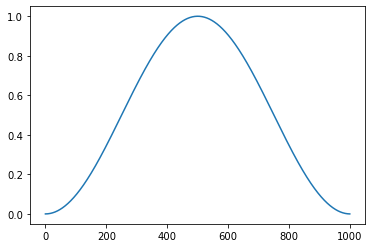

In [156]:
w = [0.5*(1-np.cos((2*np.pi*n)/N)) for n in range(0,N)]
plt.plot(w)